<a href="https://colab.research.google.com/github/KhaSab5292/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = '/content/drive/My Drive/Lambda/Unit 2 DS9/Unit 2 Build/Police_Department_Incidents_-_Previous_Year__2016_.csv'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(150500, 13)


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000


# **Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.**


In [9]:
df.describe()

,IncidntNum,X,Y,PdId
count,1.505000e+05,150500.000000,150500.000000,1.505000e+05
mean,1.616440e+08,-122.423599,37.768921,1.616440e+13
std,5.535976e+06,0.026210,0.023637,5.535976e+11
min,1.135121e+07,-122.513642,37.707922,1.135121e+12
25%,1.603283e+08,-122.434036,37.756486,1.603283e+13
50%,1.606541e+08,-122.416903,37.775421,1.606541e+13
75%,1.609764e+08,-122.406605,37.785063,1.609764e+13
max,9.910090e+08,-122.365565,37.819975,9.910090e+13


In [10]:
df.describe(exclude = 'number')

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Location
count,150500,150500,150500,150500,150500,150499,150500,150500,150500
unique,39,726,7,366,1439,10,14,16130,19386
top,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,01/01/2016 12:00:00 AM,12:00,SOUTHERN,NONE,800 Block of BRYANT ST,"(37.775420706711, -122.403404791479)"
freq,40409,17741,23371,558,3842,28445,107780,3561,3536


In [11]:
exluded_columns = ['IncidntNum', 'Descript', 'Date', 'Time', 'PdId', 'Address', 'Location']

df['Resolution'].value_counts()

NONE                                      107780
ARREST, BOOKED                             39416
UNFOUNDED                                   1608
JUVENILE BOOKED                             1056
EXCEPTIONAL CLEARANCE                        371
ARREST, CITED                                144
CLEARED-CONTACT JUVENILE FOR MORE INFO        58
NOT PROSECUTED                                22
LOCATED                                       20
PSYCHOPATHIC CASE                             17
JUVENILE CITED                                 3
JUVENILE DIVERTED                              2
COMPLAINANT REFUSES TO PROSECUTE               2
PROSECUTED BY OUTSIDE AGENCY                   1
Name: Resolution, dtype: int64

In [12]:
df['Category'].value_counts()


LARCENY/THEFT                  40409
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
L

In [13]:
df['PdDistrict'].value_counts()

SOUTHERN      28445
NORTHERN      20100
MISSION       19503
CENTRAL       17666
BAYVIEW       14303
INGLESIDE     11594
TARAVAL       11325
TENDERLOIN     9942
RICHMOND       8922
PARK           8699
Name: PdDistrict, dtype: int64

In [0]:
def clean(X):
  X = X.copy()
  X['Date'] = pd.to_datetime(X['Date'])

  X['Month'] = X['Date'].dt.month
  X = X.drop(columns = exluded_columns)
  X = X[X['Category'] != 'TREA']
  
  X['Resolution'] = X['Resolution'].replace(['ARREST, BOOKED', 'ARREST, CITED'], 
                                            'ARRESTED')
  X['Resolution'] = X['Resolution'].replace(['JUVENILE BOOKED', 'JUVENILE CITED', 'JUVENILE CITED', 'JUVENILE DIVERTED'], 
                                            'JUVENILE')
  X['Resolution'] = X['Resolution'].replace('COMPLAINANT REFUSES TO PROSECUTE', 'NOT PROSECUTED')
  X['Resolution'] = X['Resolution'].replace(['CLEARED-CONTACT JUVENILE FOR MORE INFO', 'EXCEPTIONAL CLEARANCE'],
                                            'CLEARED')
  
  X['Category'] = X['Category'].replace(['SEX OFFENSES, NON FORCIBLE', 'SEX OFFENSES, FORCIBLE'], 
                                        'SEX OFFENSES')
  X['Category'] = X['Category'].replace(['LARCENY/THEFT', 'ROBBERY', 'BURGLARY', 'STOLEN PROPERTY'], 
                                        'THEFT')
  X['Category'] = X['Category'].replace(['FORGERY/COUNTERFEITING', 'BAD CHECKS'],
                                        'FRAUD')

  return X

dfclean = clean(df)

In [16]:
dfclean['Resolution'].value_counts()

NONE                            107778
ARRESTED                         39559
UNFOUNDED                         1608
JUVENILE                          1061
CLEARED                            429
NOT PROSECUTED                      24
LOCATED                             20
PSYCHOPATHIC CASE                   17
PROSECUTED BY OUTSIDE AGENCY         1
Name: Resolution, dtype: int64

In [17]:
dfclean['Category'].value_counts()

THEFT                          50392
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
FRAUD                           3288
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES                     980
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
LIQUOR LAWS                      156
RUNAWAY                          140
SUICIDE                           69
BRIBERY                           66
E

# **Begin with baseline.**

In [46]:
dfclean['Resolution'].value_counts(normalize = True)

NONE                            0.716147
ARRESTED                        0.262856
UNFOUNDED                       0.010685
JUVENILE                        0.007050
CLEARED                         0.002851
NOT PROSECUTED                  0.000159
LOCATED                         0.000133
PSYCHOPATHIC CASE               0.000113
PROSECUTED BY OUTSIDE AGENCY    0.000007
Name: Resolution, dtype: float64

In [53]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

target = 'Resolution'
y_pred = [dfclean[target].mode()] * len(dfclean)
base_auc = accuracy_score(dfclean[target], y_pred)
base_f1 = f1_score(dfclean[target], y_pred, average = 'weighted')
print('Baseline accuracy score:', base_auc)
print('Baseline f1 score:', base_f1)

Baseline accuracy score: 0.7161471657242338
Baseline f1 score: 0.5976955510787065


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
print(classification_report(dfclean[target], y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                              precision    recall  f1-score   support

                    ARRESTED       0.00      0.00      0.00     39559
                     CLEARED       0.00      0.00      0.00       429
                    JUVENILE       0.00      0.00      0.00      1061
                     LOCATED       0.00      0.00      0.00        20
                        NONE       0.72      1.00      0.83    107778
              NOT PROSECUTED       0.00      0.00      0.00        24
PROSECUTED BY OUTSIDE AGENCY       0.00      0.00      0.00         1
           PSYCHOPATHIC CASE       0.00      0.00      0.00        17
                   UNFOUNDED       0.00      0.00      0.00      1608

                    accuracy                           0.72    150497
                   macro avg       0.08      0.11      0.09    150497
                weighted avg       0.51      0.72      0.60    150497



# **Fit a model**

In [43]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfclean, train_size = 0.8, test_size = 0.2,  
                               random_state = 42)

dfclean.shape, train.shape, test.shape

((150497, 7), (120397, 7), (30100, 7))

In [44]:
train, val = train_test_split(train, train_size = 0.75, test_size = 0.25,  
                               random_state = 42)

train.shape, val.shape, test.shape

((90297, 7), (30100, 7), (30100, 7))

In [0]:
# Arrange data into X features matrix and y target vector
target = 'Resolution'
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]

 tree-based model

In [58]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

rf = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy = 'median'), 
    RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
)

# Fit on train
rf.fit(X_train, y_train)
# score on val
print('Validation Accuracy',rf.score(X_val, y_val))

Validation Accuracy 0.8417275747508306


In [59]:
# f1 score on val
y_pred = rf.predict(X_val)
val_f1 = f1_score(y_val, y_pred, average = 'weighted')
print('Validation f1 score:', val_f1)

Validation f1 score: 0.8351028357334149


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
print(classification_report(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                              precision    recall  f1-score   support

                    ARRESTED       0.75      0.68      0.71      7855
                     CLEARED       0.76      0.19      0.31        83
                    JUVENILE       0.59      0.15      0.24       210
                     LOCATED       1.00      0.50      0.67         2
                        NONE       0.87      0.92      0.90     21605
              NOT PROSECUTED       0.33      0.20      0.25         5
PROSECUTED BY OUTSIDE AGENCY       0.00      0.00      0.00         1
           PSYCHOPATHIC CASE       0.50      0.17      0.25         6
                   UNFOUNDED       0.79      0.22      0.34       333

                    accuracy                           0.84     30100
                   macro avg       0.62      0.34      0.41     30100
                weighted avg       0.84      0.84      0.84     30100



linear model

In [61]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

log = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy = 'median'), 
    LogisticRegressionCV(cv = 5, n_jobs = -1, random_state = 42)
)

# Fit on train
log.fit(X_train, y_train)
# score on val
print('Validation Accuracy', log.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Validation Accuracy 0.7141528239202658


In [62]:
# f1 score on val
y_pred = log.predict(X_val)
val_f1 = f1_score(y_val, y_pred, average = 'weighted')
print('Validation f1 score:', val_f1)

Validation f1 score: 0.6198700117330118


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
print(classification_report(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                              precision    recall  f1-score   support

                    ARRESTED       0.43      0.05      0.09      7855
                     CLEARED       0.00      0.00      0.00        83
                    JUVENILE       0.00      0.00      0.00       210
                     LOCATED       0.00      0.00      0.00         2
                        NONE       0.72      0.98      0.83     21605
              NOT PROSECUTED       0.00      0.00      0.00         5
PROSECUTED BY OUTSIDE AGENCY       0.00      0.00      0.00         1
           PSYCHOPATHIC CASE       0.00      0.00      0.00         6
                   UNFOUNDED       0.00      0.00      0.00       333

                    accuracy                           0.71     30100
                   macro avg       0.13      0.11      0.10     30100
                weighted avg       0.63      0.71      0.62     30100



# **Make at least 1 partial dependence plot to explain your model.**

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

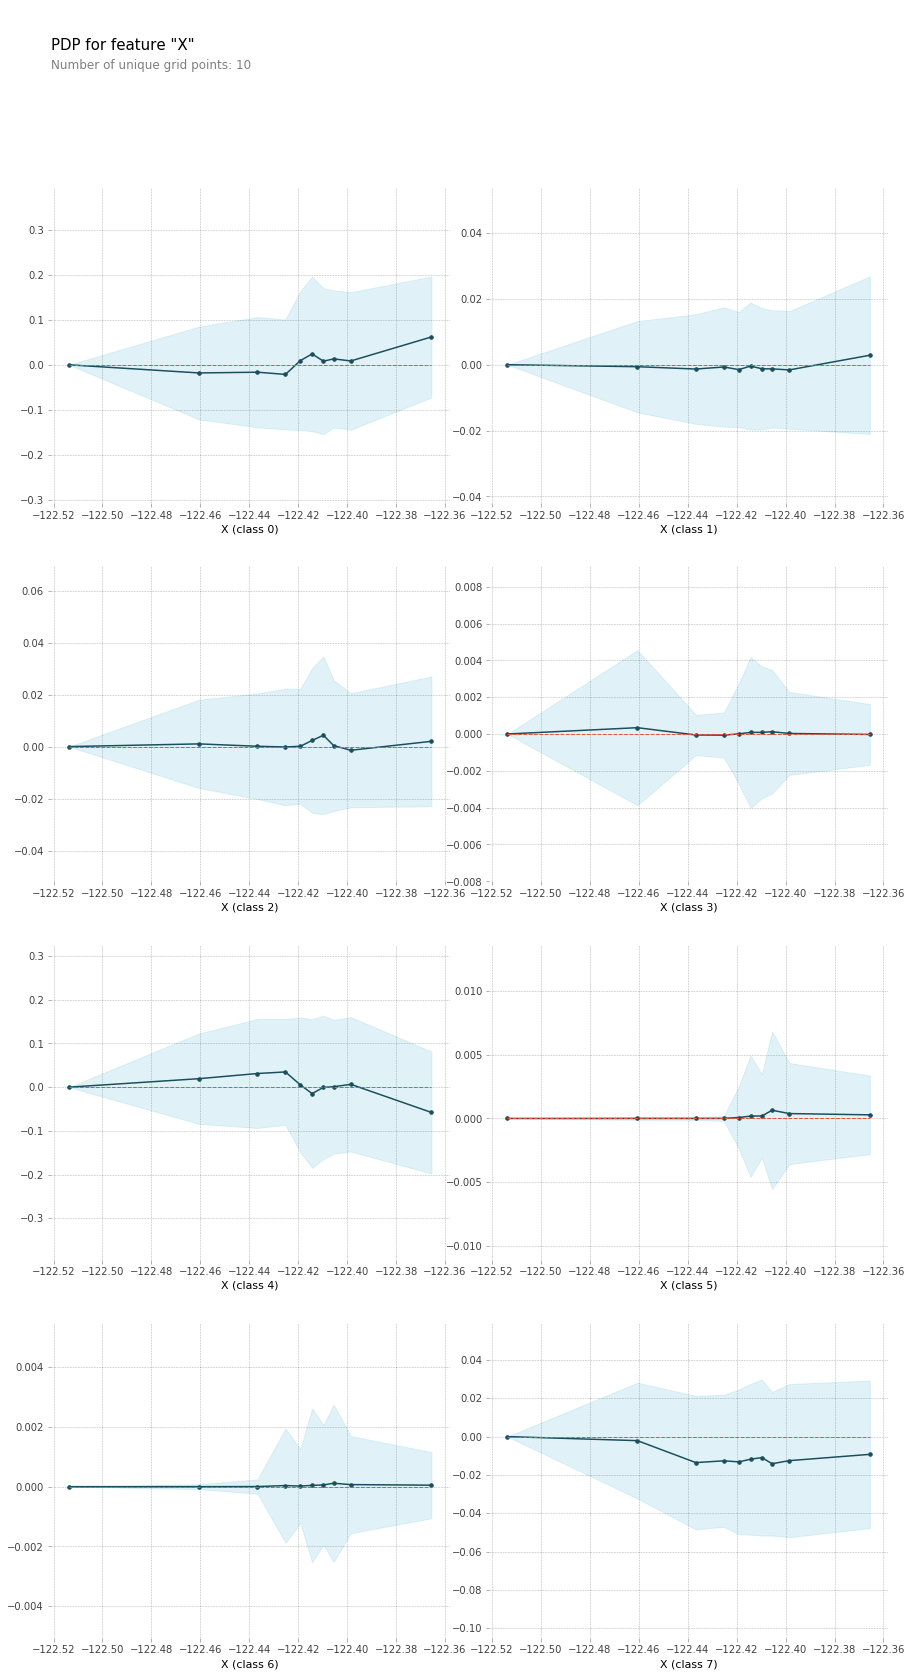

In [97]:
feature = 'X'

isolated = pdp_isolate(
    model = rf, 
    dataset = X_val, 
    model_features = X_val.columns, 
    feature = feature
)

pdp_plot(isolated, feature_name = feature);

In [95]:
from pdpbox import pdp

encoder = ce.OrdinalEncoder() 
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
# Fit on train
model.fit(X_train_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

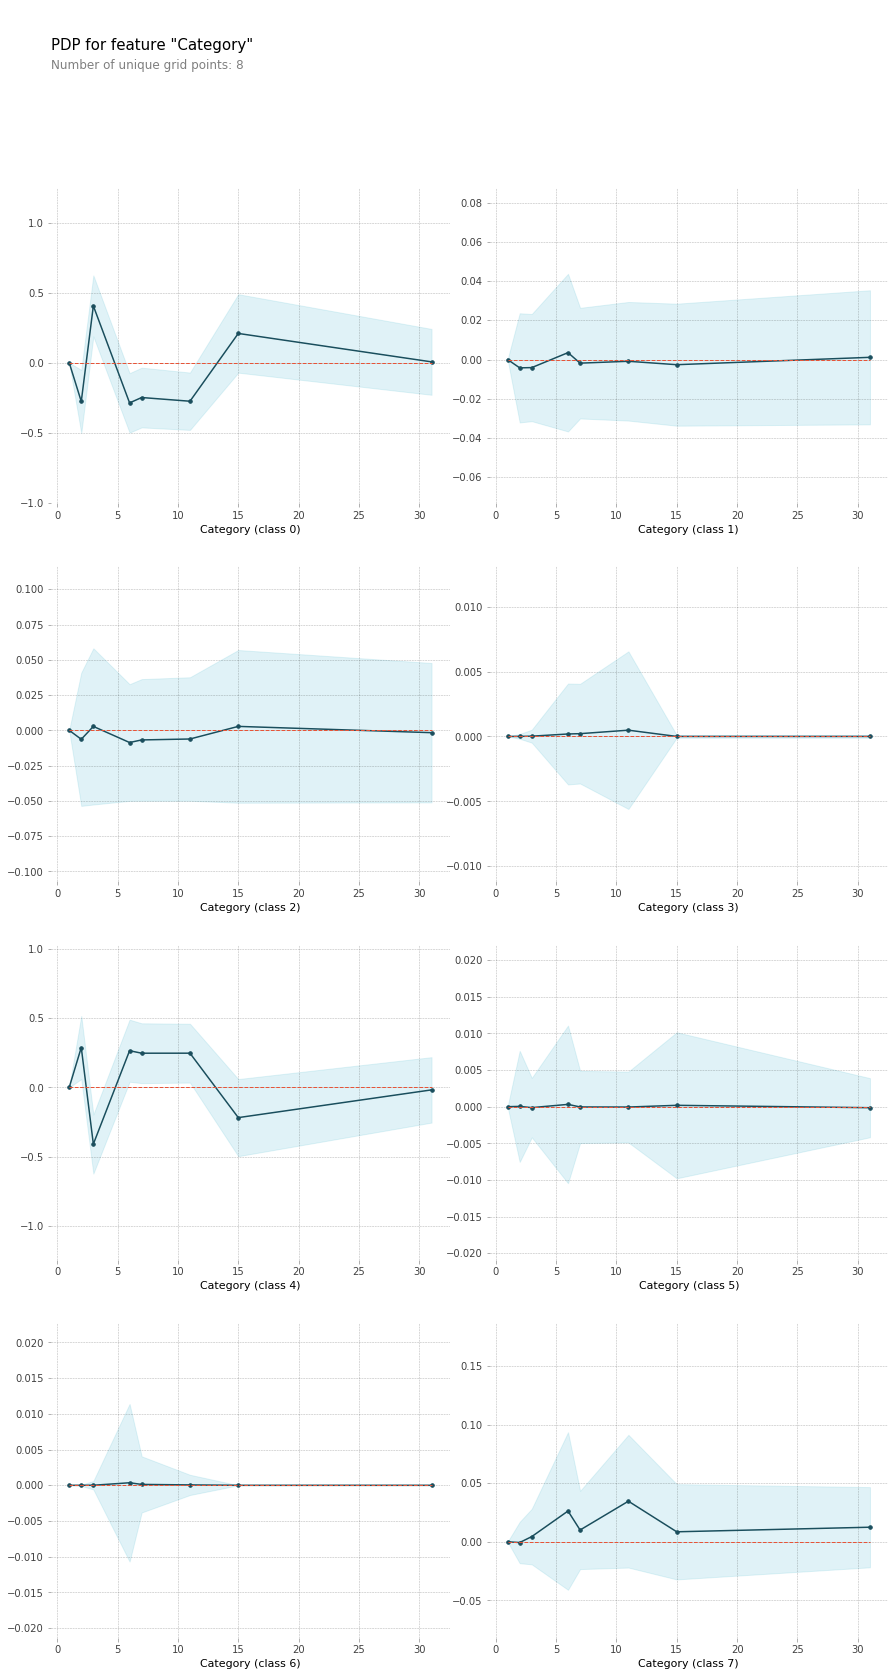

In [96]:
feature = 'Category'

pdp_dist = pdp.pdp_isolate(
    model = model, 
    dataset = X_val_encoded, 
    model_features = X_val.columns, 
    feature = feature
)

pdp.pdp_plot(pdp_dist, feature);